# Test 4 - Comparaison gains PINNs/PINNs+Corr et FEM/PINNs+Corr

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les gains obtenues pour

- PINNs vs PINNs + Correction par addition
- FEM vs PINNs + Correction par addition

On choisira d'effectuer ces comparaisons sur 2 tailles de grilles fixées (20x20 et 40x40) en sélectionnant 50 paramètres aléatoires.

## Imports + Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

from fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from solver_fem import FEMSolver
from utils import create_tree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [3]:
# sélection du cas test
testcase = 1
degree = 1

if testcase == 1:
    from test_1 import Run_laplacian2D,Poisson_2D
    from problem import TestCase1
    problem = TestCase1()
    dim_params = problem.nb_parameters
    result_dir = "results/4_facteurs/"
    create_tree(result_dir)
else:
    raise ValueError("Testcase not found")

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

torch loaded; device is cuda
hmax =  0.23383594411359887
hmax =  0.11392007533739443


/home/flecourtier/Bureau/Article1/results/3_convergence
>> load network /home/flecourtier/Bureau/Article1/results/3_convergence/networks/test_fe1.pth
jsbdbshd
network loaded


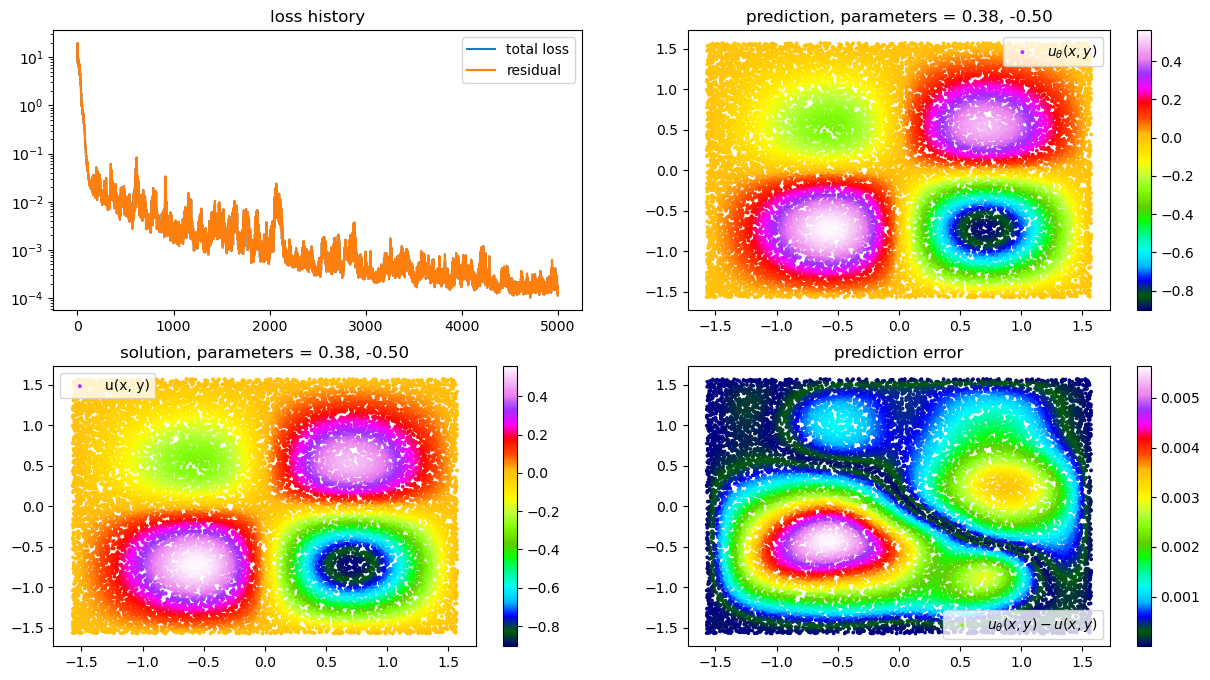

In [4]:
pde = Poisson_2D(problem)
trainer,u_theta = Run_laplacian2D(pde)

In [5]:
def get_params(n):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick n random parameters for each dimension
    params = []
    for i in range(dim_params):
        parami = np.random.uniform(parameter_domain[i][0], parameter_domain[i][1], n)
        params.append(parami)
    params = np.array(params).T
    return params

np.random.seed(0)
n_params = 10
params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)}" for i in range(n_params)])

## Erreurs FEM

In [6]:
def read_csv_FEM(testcase,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_degree{degree}.csv')
    tab_err_FEM = df_FEM.values[2:,1:]
    return tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_degree{degree}.csv'
    col_names = [("FEM",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
        
    if not new_run and os.path.exists(csv_file):
        tab_err_FEM = read_csv_FEM(testcase,degree)
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_FEM = np.zeros((n_params,len(tab_nb_vert)))
        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                _,norme_L2 = solver.fem(i)
                tab_err_FEM[i,j] = norme_L2
            print()
        
        df_FEM = pd.DataFrame(tab_err_FEM,columns=mi)
        df_FEM.to_csv(csv_file)
           
    return df_FEM, tab_err_FEM

In [7]:
df_FEM, tab_err_FEM = run_FEM(degree)

nb_vert=20
hmax =  0.23383594411359887
param = 0 1 2 3 4 5 6 7 8 9 
nb_vert=40
hmax =  0.11392007533739443
param = 0 1 2 3 4 5 6 7 8 9 


## Erreurs PINNs

In [8]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [9]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                param = params[i]
                u_ex = UexExpr(param, degree=degree_PINNs, domain=solver.mesh, pb_considered=problem)

                uex_Vex = df.interpolate(u_ex,solver.V_ex)
                norme_L2 = (df.assemble((((uex_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uex_Vex)) ** 2) * solver.dx) ** (0.5))
            
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

In [10]:
df_PINNs, tab_err_PINNs = run_PINNs(degree)

nb_vert=20
hmax =  0.23383594411359887
param = 0 1 2 3 4 5 6 7 8 9 
nb_vert=40
hmax =  0.11392007533739443
param = 0 1 2 3 4 5 6 7 8 9 


## Erreurs Corr

In [11]:
def read_csv_Corr(testcase,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_degree{degree}.csv')
    tab_err_Corr = df_Corr.values[2:,1:]
    
    return tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_degree{degree}.csv'
    col_names = [("Corr",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        df_Corr, tab_err_Corr = read_csv_Corr(testcase,degree)
        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        tab_err_Corr = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_Corr = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_Corr)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()
                
                _,_,norme_L2 = solver.corr_add(i,u_PINNs)
                tab_err_Corr[i,j] = norme_L2
            print()

        df_Corr = pd.DataFrame(tab_err_Corr,columns=mi)
        df_Corr.to_csv(csv_file)
        
    return df_Corr, tab_err_Corr

In [12]:
df_Corr, tab_err_Corr = run_Corr(degree)

nb_vert=20
hmax =  0.23383594411359887
param = 0 1 2 3 4 5 6 7 8 9 
nb_vert=40
hmax =  0.11392007533739443
param = 0 1 2 3 4 5 6 7 8 9 


## Dataframe erreurs

In [13]:
# concatenate dataframe : for each columns, we have the error for each method
# we want a multiindex dataframe with FEM, PINNs and Corr for each n_vert and h
col_names = [("FEM",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("PINNs",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))] + \
        [("Corr",str(tab_nb_vert[i]),str(tab_h[i])) for i in range(len(tab_nb_vert))]

mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
row_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df = pd.DataFrame(columns=mi,index=row_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j]] = tab_err_FEM[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j2+j]] = tab_err_PINNs[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df.loc[row_names[i],col_names[j3+j]] = tab_err_Corr[i,j]
        
df.to_csv(result_dir+f'comparison_case{testcase}_degree{degree}.csv')

## Dataframe facteurs

In [14]:
facteurs_PINNs_Corr = df["PINNs"] / df["Corr"]
facteurs_FEM_PINNs = df["FEM"] / df["PINNs"]
facteurs_FEM_Corr = df["FEM"] / df["Corr"]

col_names = [("FEM/PINNs",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("PINNs/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))] + \
        [("FEM/Corr",str(tab_nb_vert[i]),str(tab_h[i].round(2))) for i in range(len(tab_nb_vert))]
mi = pd.MultiIndex.from_tuples(col_names, names=["facteurs","n_vert","h"])

index_names = [str(i) + " : " + params_str[i] for i in range(n_params)]
df_facteurs = pd.DataFrame(columns=mi,index=index_names)

for i in range(n_params):
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j]] = facteurs_FEM_PINNs.to_numpy()[i,j]
        j2=j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j2+j]] = facteurs_PINNs_Corr.to_numpy()[i,j]
        j3 = j2+j+1
    for j in range(len(tab_nb_vert)):
        df_facteurs.loc[index_names[i],col_names[j3+j]] = facteurs_FEM_Corr.to_numpy()[i,j]
        
df_facteurs.to_csv(result_dir+f'comparison_facteurs_case{testcase}_degree{degree}.csv')


## Boxplots

In [15]:
sns.set_style('darkgrid')
sns.set_theme(style="ticks")
sns.set_context("paper")
    
def plot_boxplot(i):
    n_vert = tab_nb_vert[i]
    
    # on crée une dataframe contenant les facteurs pour chaque méthode avec n_vert=n_vert
    df_facteurs_n_vert = df_facteurs[[col for col in df_facteurs.columns if col[1] == str(n_vert)]]
    # on supprime la première colonne 
    df_facteurs_n_vert = df_facteurs_n_vert.drop(columns=[df_facteurs_n_vert.columns[0]])
    
    # on change les noms des colonnes
    df_facteurs_n_vert.columns = [col[0] for col in df_facteurs_n_vert.columns]

    sns.boxplot(data=df_facteurs_n_vert, orient="h", palette="Set2")
    plt.grid(axis="x", visible=True, which="both")
    plt.title(f"n_vert={n_vert}")
    
    return df_facteurs_n_vert

def plot_table(df_facteurs_n_vert,ax):
    df_min = df_facteurs_n_vert.min(axis=0)
    df_max = df_facteurs_n_vert.max(axis=0)
    df_mean = df_facteurs_n_vert.mean(axis=0)
    
    df_val = pd.concat([df_min,df_max,df_mean],axis=1).T
    tab = df_val.values.T.astype(float)
    tab = np.round(tab,2)

    thetable = ax.table(cellText=tab, rowLabels=df_facteurs_n_vert.columns, colLabels=["min","max","mean"], loc='right', cellLoc='center', colLoc='center', bbox=[0,0,1,1])
    thetable.scale(1.,0.8)
    thetable.auto_set_font_size(False)
    
    ax.axis('off')

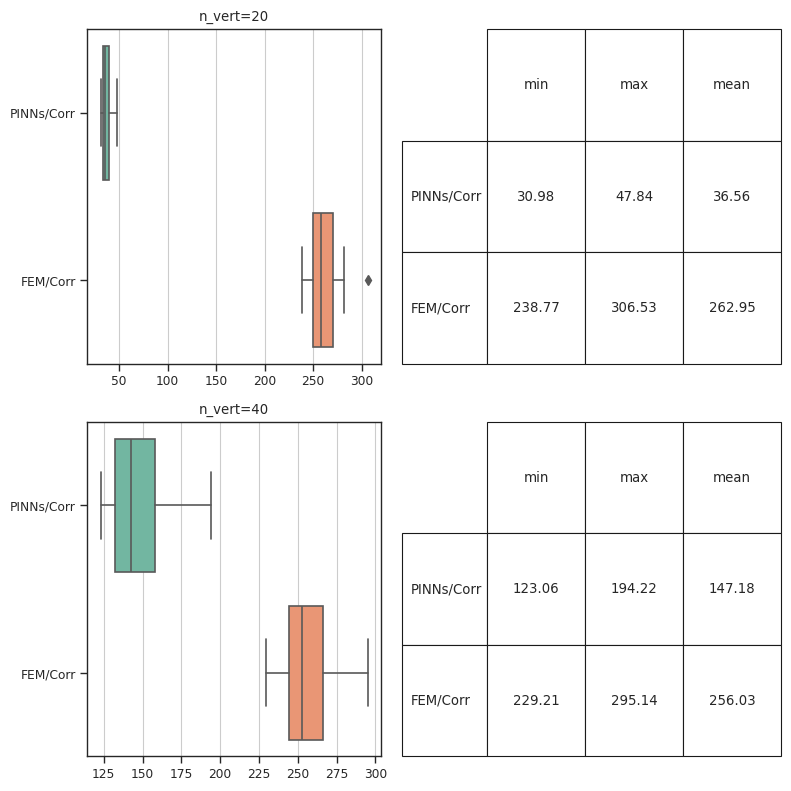

In [16]:
nb_test = len(tab_nb_vert)

plt.figure(figsize=(8,nb_test*4))

for i in range(nb_test):
    plt.subplot(nb_test,2,2*i+1)
    df_facteurs_n_vert = plot_boxplot(i)

    ax = plt.subplot(nb_test,2,2*i+2)
    plot_table(df_facteurs_n_vert,ax)

plt.tight_layout()
plt.savefig(result_dir+f'boxplot_facteurs_case{testcase}_degree{degree}.png')
plt.show()